In [90]:
#!/usr/bin/env python
# coding: utf-8

# This script explores CNN model performance based on training image resolution.
# We test the following training image sizes:
# 64 x 64, 128 x 128, 224 x 224, 384 x 384

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from timeit import default_timer as timer
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()

# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [64,128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_MODEL_RUNS = 10
NUM_EPOCHS = 10
SCENARIO_PERFORMANCE_METRICS_DIR = '../../results/models/'

In [2]:
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)


In [61]:

# def recall(y_true, y_pred):
# 	y_true, y_pred = check_units(y_true, y_pred)
# 	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
# 	possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
# 	recall = true_positives / (possible_positives + K.epsilon())
# 	return recall

# def f1(y_true, y_pred):
# 	y_true, y_pred = check_units(y_true, y_pred)
# 	precision = precision(y_true, y_pred)
# 	recall = recall(y_true, y_pred)
# 	return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Metrics2 modified from https://stackoverflow.com/a/61856587/3023033
class Metrics2(Callback):
    def __init__(self, val_data):#, batch_size = 64):
        super().__init__()
        self.validation_data = val_data
        #self.batch_size = batch_size

    def on_train_begin(self, logs={}):
        #print(self.validation_data)
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        #batches = len(self.validation_data)
        #total = batches * self.batch_size

        #val_pred = np.zeros((total,1))
        #val_true = np.zeros((total))

        xVal, yVal = self.validation_data
        val_pred = np.argmax(np.asarray(self.model.predict(xVal)), axis=1)
        val_true = np.argmax(yVal, axis=1)        
        #val_pred = np.squeeze(val_pred)
        _val_f1 = f1_score(val_true, val_pred, average='weighted', zero_division = 0)
        _val_precision = precision_score(val_true, val_pred, average='weighted', zero_division = 0)
        _val_recall = recall_score(val_true, val_pred, average='weighted', zero_division = 0)

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print('— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        return

In [103]:
def trainModelWithDetailedMetrics(image_size, scenario, num_epochs = 10, trial_seed = 1): 
    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.75, seed_num = trial_seed)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    
    # CALLBACKS
    model_metrics = Metrics2(val_data=(validation_images, validation_labels))
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    # batch_training_histories = Histories()
    K.clear_session()

    input_shape = (image_size, image_size, NUM_CHANNELS)
    model = constructBaseCNN(image_size, scenario, num_channels = NUM_CHANNELS)
    opt_learning_rate = getOptCNNHyperparams(image_size, scenario)['learning_rate']
    reset_weights(model) # re-initialize model weights
    opt = tf.keras.optimizers.Adam(learning_rate = opt_learning_rate)
    
    model.compile(loss='categorical_crossentropy',  optimizer = opt, metrics =  ['accuracy']) 

    model_name = "opt-cnn-" + scenario + "-" +str(image_size) + "-px"
    model_folder = "model"
    #model.save(os.path.join(SCENARIO_PERFORMANCE_METRICS_DIR, model_name, model_folder))
    filename = "performance.txt"

    hist = model.fit(training_images, training_labels, batch_size = 64, epochs = num_epochs, verbose=1, 
                     validation_data=(validation_images, validation_labels),
                     callbacks = [model_metrics, early_stopping]) #, callbacks=[batch_training_histories])
    class_labels = getClassLabels(scenario)
    
    
    
    y_pred = np.argmax(model.predict(validation_images), axis=-1) 
    report = classification_report(np.argmax(validation_labels, axis=-1), y_pred, zero_division=0,
                                   labels = np.arange(len(class_labels)), target_names=class_labels)
    print("Classification report for scenario " + scenario + ", resolution: " + str(image_size) + ":")
    print(report)
    con_mat = tf.math.confusion_matrix(labels=np.argmax(validation_labels, axis=-1), predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat, index = class_labels, columns = class_labels)

    print("Confusion matrix for scenario " + scenario + ", resolution: " + str(image_size) + ":")
    print(con_mat_df)
    figure = plt.figure()#figsize=(4, 4))
    ax = sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, fmt='g')
    plt.tight_layout()
    plt.ylabel('True')
    ax.set_yticklabels(class_labels, ha='center')
    ax.set_xticklabels(class_labels, ha='center')
    plt.xlabel('Predicted')
    plt.show()
    return(hist) #performance_dict)



Epoch 1/2
30/30 [==============================] - 12s 367ms/step - loss: 0.9995 - accuracy: 0.8125 - val_loss: 3.3949 - val_accuracy: 0.0079
— val_f1: 0.000124 — val_precision: 0.000063 — val_recall 0.007911
Epoch 2/2
30/30 [==============================] - 10s 340ms/step - loss: 0.5029 - accuracy: 0.9602 - val_loss: 10.9775 - val_accuracy: 0.0079
— val_f1: 0.000124 — val_precision: 0.000063 — val_recall 0.007911
Classification report for scenario Pr_Po_Im, resolution: 64:
              precision    recall  f1-score   support

    Probable       0.00      0.00      0.00         0
    Possible       0.01      1.00      0.02         5
  Improbable       0.00      0.00      0.00       627

   micro avg       0.01      0.01      0.01       632
   macro avg       0.00      0.33      0.01       632
weighted avg       0.00      0.01      0.00       632

Confusion matrix for scenario Pr_Po_Im, resolution: 64:
            Probable  Possible  Improbable
Probable           0         0          

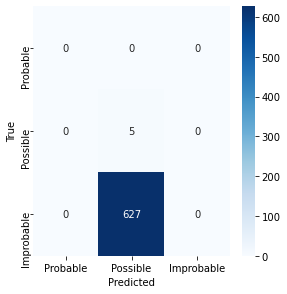

In [104]:
h = trainModelWithDetailedMetrics(64, "Pr_Po_Im", num_epochs = 2)

In [24]:
#tf.executing_eagerly()

True

In [94]:
h.history
#pd.DataFrame.from_dict(h.history).plot()

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
# y_pred = final.predict(X_test)
# y_indx = np.argmax(y_test_new, axis = 1)
# pred_indx = np.argmax(y_pred, axis = 1)
# print(classification_report(y_indx, pred_indx))

# def main(num_trials = NUM_MODEL_RUNS):
#     if not os.path.exists(RESOLUTION_PERFORMANCE_METRICS_DIR): # check if 'tidy/preprocessed_images' subdirectory does not exist
#         os.makedirs(RESOLUTION_PERFORMANCE_METRICS_DIR) # if not, create it    
#     for s in SCENARIO_LIST:
#         for p in RESOLUTION_LIST:
#             for i in range(num_trials):
#                 print("Conducting performance test: Scenario - " + s + "; Resolution - " + str(p) + "px; Trial - " + str(i+1))
#                 scenario_performance_dict = testResolutionScenarioPerformance(p, s, num_epochs = NUM_EPOCHS, trial_seed = 1 + i) #ultimately should be averaged across trials       
#                 scenario_filename = "scenario_resolution_performance_" + s + str(p) + "px_trial_" + str(i+1) + ".txt"
#                 with open(os.path.join(RESOLUTION_PERFORMANCE_METRICS_DIR, scenario_filename), 'w') as f:
#                    f.write(json.dumps(scenario_performance_dict )) # use `json.loads` to do the reverse)
#     return


# if __name__ == "__main__":
#     main()


# predictions = model.predict_classes(x_val)
# predictions = predictions.reshape(1,-1)[0]

# print(classification_report(y_val, predictions, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))v

In [ ]:
    
#     metrics = [
#     tfma.metrics.ExampleCount(name='example_count'),
#     tfma.metrics.WeightedExampleCount(name='weighted_example_count'),
#     tf.keras.metrics.SparseCategoricalCrossentropy(
#         name='sparse_categorical_crossentropy'),
#     tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
#     tf.keras.metrics.Precision(name='precision', top_k=1),
#     #tf.keras.metrics.Precision(name='precision', top_k=3),
#     tf.keras.metrics.Recall(name='recall', top_k=1),
#     #tf.keras.metrics.Recall(name='recall', top_k=3),
#     tfma.metrics.MultiClassConfusionMatrixPlot(
#         name='multi_class_confusion_matrix_plot'),]
#     metrics_specs = tfma.metrics.specs_from_metrics(metrics)
#     metrics_specs = tfma.metrics.specs_from_metrics(metrics,
#         aggregate=tfma.AggregationOptions(
#             macro_average=True, class_weights={i: 1.0 for i in range(3)}))


    # performance_dict = {}    
    # performance_dict['scenario'] = scenario
    # performance_dict['image_size'] = image_size
    # performance_dict['metrics'] = hist.history
    # performance_dict['best_val_accuracy'] = np.max(hist.history['val_accuracy'])
